In [2]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import torch 
from sklearn.model_selection import train_test_split

import cv2
from tqdm import tqdm
from os import walk
import matplotlib.pyplot as plt
import random
from skimage.transform import resize 
from tensorflow.keras import utils 
from scipy.ndimage import rotate
import gc

from sklearn.metrics import confusion_matrix
from PIL import Image
from typing import Union
import numpy as np
from numpy import asarray

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

!unzip -u "/content/drive/MyDrive/smartathon/dataset.zip" -d "/content/datasets"

Streaming output truncated to the last 5000 lines.
  inflating: /content/datasets/dataset/images/fa2405166ec7764b052959f55b2cb21e.jpg  
  inflating: /content/datasets/dataset/images/2c6cfe092f7ae14cd67f79633e7b329c.jpg  
  inflating: /content/datasets/dataset/images/e25504419a506119a04982130738469a.jpg  
  inflating: /content/datasets/dataset/images/c690dd80504ff3956e1e50a2fbc7c7f4.jpg  
  inflating: /content/datasets/dataset/images/e4b35fb8567c0d8d99de36e96bc4fde9.jpg  
  inflating: /content/datasets/dataset/images/beaf13e79379657b526c349e95821023.jpg  
  inflating: /content/datasets/dataset/images/4e90d0fe2795542468fb5d1cc1834c10.jpg  
  inflating: /content/datasets/dataset/images/5235b7a1aef39d0539839873d5a3418a.jpg  
  inflating: /content/datasets/dataset/images/f48ae52f06f8075c628e6a438e93426f.jpg  
  inflating: /content/datasets/dataset/images/133d32aab2d56507ccb45c9609b2ec48.jpg  
  inflating: /content/datasets/dataset/images/f30492c8c7d9b5d4d939e6035fa73170.jpg  
  inflating: /

In [5]:
def to_np(x):
  x = 2*np.array(x,dtype=np.int32)
  return np.where(x<0,0,x)

  
df  = pd.read_csv('/content/datasets/dataset/train.csv')
df['class'] = df['class'].astype(int)
label_map= dict(zip(df['name'].unique().tolist(),df['class'].unique().tolist()))
df['coords'] = df[['xmin','ymin','xmax','ymax']].apply(to_np,axis=1)
df = df.drop(['xmin','ymin','xmax','ymax'],axis=1)
df.head()

,class,image_path,name,coords
0,3,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,"[1402, 422, 1594, 524]"
1,3,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,"[1572, 476, 1864, 658]"
2,3,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,"[1314, 458, 1472, 550]"
3,7,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,"[1572, 0, 1972, 272]"
4,8,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,"[1098, 358, 1334, 456]"


In [6]:
df = df.drop(df[df['class']==3].index, axis=0)
df.head()

,class,image_path,name,coords
3,7,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,"[1572, 0, 1972, 272]"
4,8,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,"[1098, 358, 1334, 456]"
5,8,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,"[1256, 352, 1598, 476]"
6,8,8ca1b825716ea6755180fde347ac79c1.jpg,SAND_ON_ROAD,"[868, 294, 1064, 392]"
7,0,8ca1b825716ea6755180fde347ac79c1.jpg,GRAFFITI,"[942, 262, 1098, 354]"


In [7]:
df['class'].value_counts()

4     2730
2     2625
9     2253
7     1555
0     1124
8      748
10     127
1      107
5       83
6        1
Name: class, dtype: int64

In [8]:
def crop_to_bbox(img,st_point:Union[tf.Tensor,np.array],end_point:Union[tf.Tensor,np.array]):
    """
    img: numpy array or tf.tensor of shape (height,width,channel)
    st_point :  tf.tensor or numpy array (xmin,ymin)
    end_point: tf.tensor or numpy array (xmax,ymax)
    """
    img = tf.convert_to_tensor(img)
    wh = (end_point-st_point)
    return tf.image.crop_to_bounding_box(img,st_point[1],st_point[0],wh[1],wh[0])

#test cropping

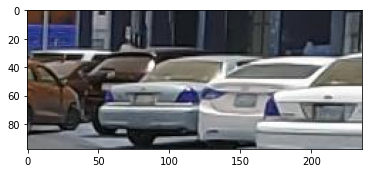

In [9]:
coords =np.array([1098, 358, 1334, 456])

# img = os.path.join('/content/datasets/dataset/images/','1c7d48005a12d1b19261b8e71df7cafe.jpg')
img = os.path.join('/content/datasets/dataset/images/', df['image_path'].values[0])
img= crop_to_bbox(cv2.imread(img),coords[:2],coords[2:])
plt.imshow(img)

<class 'tensorflow.python.framework.ops.EagerTensor'>


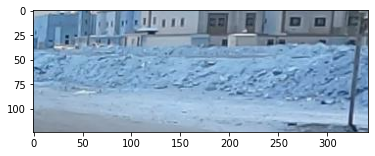

In [10]:
img = os.path.join('/content/datasets/dataset/images/', df['image_path'].values[2])
img_cropped= crop_to_bbox(cv2.imread(img),df.coords.values[2][:2],df.coords.values[2][2:])
plt.imshow(img_cropped)
# new_img_name = os.path.join('/content/datasets/dataset/images_cropped/', row["image_path"][:-4] + str(index) + row["image_path"][-4:])
new_img_name = os.path.join('/content/', "test.jpg")
print(type(img_cropped))
# tf.keras.utils.save_img(new_img_name, img_cropped)

#Saving the cropped images and creating the dataframe

In [ ]:
# import shutil

# shutil.rmtree('/content/datasets/dataset/images_cropped/')

In [ ]:
error_img = 0
for index, row in df.iterrows():
  try:
    img = os.path.join('/content/datasets/dataset/images/', row['image_path'])
    img_cropped= crop_to_bbox(cv2.imread(img),row.coords[:2],row.coords[2:])
    print("well done")
    # new_img_name = os.path.join('/content/datasets/dataset/images_cropped/', row["image_path"][:-4] + str(index) + row["image_path"][-4:])
    new_img_name = os.path.join('/content/datasets/dataset/images_cropped/', str(index) + ".jpg")
    tf.keras.utils.save_img(new_img_name, img_cropped)
    print("success in folder")
    
    new_row = {"image_path": new_img_name, "name": row["name"]}
    df_cropped = df_cropped.append(new_row, ignore_index=True)
    print("Success in df")
  except:
    print("error ...")
    error_img += 1

In [ ]:
df_cropped.shape

In [ ]:
df["name"].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
oh_encoder = OneHotEncoder(sparse=False)
label_var = oh_encoder.fit_transform(df_cropped[['name']])
label_names = oh_encoder.get_feature_names()
ls = []
for name in label_names:
  ls.append(name[3:])
ls

In [ ]:
df_labels = pd.DataFrame(data=label_var, columns=ls)
df_labels

In [ ]:
df = pd.concat([df_cropped, df_labels], axis=1)
df.head()